<a href="https://colab.research.google.com/github/PouyaRepos/Mutil-Armed-Bandit-Anomaly-Detection/blob/main/MAB_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy.special import erfinv, erf
from collections import Counter
import math
import itertools as it
import networkx as nx
import copy






Total number of iteration (T): 3600
List of rank of arms (S): [3600, 3600, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
List of terminated outlier arms (Ψ_hat): [38, 39]







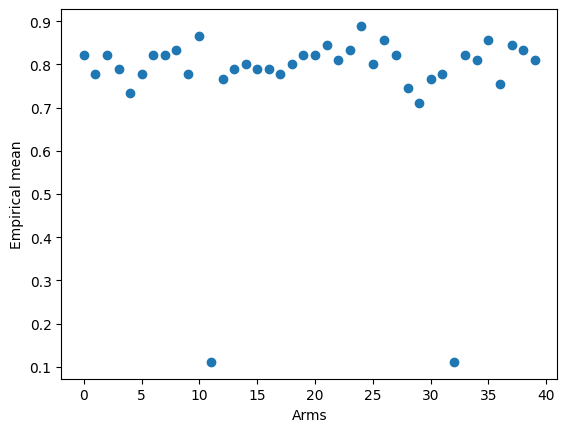

In [ ]:

# list of arms from different distributions
ϵ= 5 # ϵ
ρ = .95 # ρ
δ = .05 # δ
T = 0 # Pulling counter
Ψ_hat =[] # terminated arms
n = 40 # Number of arms
Ψ = [0] * n # number of arms
s = [0] * len(Ψ) # Rank of arms
y = [0] * len(Ψ) # empirical estimate expected rewards
m = [0] * len(Ψ) # number of pulling arm
β = [0] * len(Ψ) # Upper Confidence Bound (UCB) of y[i]
x = [ [] for _ in range(len(Ψ)) ] # Arm's reward 
R = 35 # Rewards bound (R = d-c , where x[i] is in [c, d])
b = (1 + math.e**(1/16) + ϵ )/(1 - math.e**(1/16) + ϵ ) # Coefficient function with regard to ϵ and beta



######################## Line 1 - 7
Ψ = []
for i in range(n):
  # r = np.random.uniform(-.03, .03)
  if i < (ρ*n): # 
    x[i].append(np.random.binomial(1, (.81)))
  # elif i < ((ρ*n)+1):
  #   x[i].append(np.random.binomial(1,(.9+r)))
  else:
    x[i].append(np.random.binomial(1,(0.1)))

  T += 1                            # increment total pulling round
  m[i] += 1                         # the number of pulls on arm[i] so far
  y[i] = sum(x[i])/m[i]             # empirical estimate of arm[i] expected reward
  δ_hat = (6*δ) / ((np.pi**2)*n*(T**2))        # According to Hoeffding’s inequality
  
  z = erfinv(1-δ_hat)                           # invers of error function
  p_tilda = (sum(x[i]) + ((z**2)/2)) / (m[i] + z**2)    # 
  β[i] = z * np.sqrt((p_tilda * (1 - p_tilda)) / m[i])     # According to Hoeffding’s inequality

G_ =  [ [0] * n for _ in range(n) ]        # Neighborhood Graph 



######################## Line 8 - 10

for k in it.combinations(range(n),2):
    if abs(y[k[0]]-y[k[1]]) <= b*(β[k[0]] + β[k[1]]):
        G_[k[0]][k[1]] += 1
        # G[k[1]][k[0]] += 1

G = copy.deepcopy(G_)      # Keep the intial graph unchanged
# labels = list(range(len(Ψ)))
# G_= pd.DataFrame(G_, index= labels,columns=labels) # reshape as pandas DataFrame
# M_ = sorted(nx.connected_components(nx.from_pandas_adjacency(G_))) # Connected component 
# print(f'int M_:{M_}')



######################## Line 11 - 20

while len(Ψ_hat) < round(n*(1- ρ ), 6):
    # print(f'Ψ_hat: {Ψ_hat}')
    N = set(range(n)) - set(Ψ_hat)      # NOT terminated arms
    # print(N)
    for i in N:
      # r = np.random.uniform(-.03, .03)
      if i < (ρ*n):
        x[i].append(np.random.binomial(1, .81))
      # elif i < ((ρ*n)+1):
      #   x[i].append(np.random.binomial(1,(.9+r)))
      else:
        x[i].append(np.random.binomial(1,(0.1)))

      T += 1                                           # increment total pulling round
      m[i] += 1                                        # the number of pulls on arm[i] so far

      y[i] = sum(x[i])/m[i]                            # empirical estimate of arm[i] expected reward
      δ_hat = (6* δ ) / ((np.pi**2)*n*(T**2))     # According to Hoeffding’s inequality

      z = erfinv(1-δ_hat)                               # invers of error function
      p_tilda = (sum(x[i]) + ((z**2)/2)) / (m[i] + z**2)    # 
      β[i] = z * np.sqrt((p_tilda * (1 - p_tilda)) / m[i])     # According to Hoeffding’s inequality

      

######################## Line 17: [23-28]

# UpdateG
    for k in it.combinations(range(n),2):
        # print(f'k:{k}')
        if abs(y[k[0]]-y[k[1]]) > b*(β[k[0]] + β[k[1]]):
            if G[k[1]][k[0]] == 1:
                # print('second')
                # print(G[k[0]][k[1]])
                G[k[1]][k[0]] = 0
                # print(f'Update 18 E:{G}')


######################## Line 18

# Connected component 
    labels = list(range(n))
    G = pd.DataFrame(G, index= labels,columns=labels)                # reshape as pandas DataFrame
    M = sorted(nx.connected_components(nx.from_pandas_adjacency(G))) # Connected component 

######################## Line 19: [30-36]

### Update arms_hat (terminated arms) and S (arm's rank) ###
    # print(f'Pulling round T:{T}')
    # print(f'Connected componen M: {M}')
    for c in M:
        # print(len(c) < len(Ψ)*(1- ρ))
        # print(f'c:{c}')
        if len(c) <= round(n*(1- ρ ),6):
            # print('T')
            for c_ in list(c):
                # print(f'C_:{c_}')
                s[c_] = T                              # upade arms rank
                # print(f's[c_]: {s[c_]}')
                if c_ not in Ψ_hat:
                    Ψ_hat.append(c_)                  # update terminated arms list
                    # print(f'arms_hat: {arms_hat}')       
Ω = [a for _, a in sorted(zip(s,labels))] # sort labels according to their rank 's'

print("""



""")
print(f'Total number of iteration (T): {T}')
print(f'List of rank of arms (S): {sorted(s, reverse = True)}')
print(f'List of terminated outlier arms (Ψ_hat): {Ψ_hat}')

print("""



""")
# Plot arms
np.random.shuffle(y)
plt.scatter(list(range(40)), y)
plt.ylabel("Empirical mean")
plt.xlabel('Arms')
plt.show()